### Import required libraries

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
!pip install netron
import netron
from random import randint

First of all, we define this function which split a given sequence into multiple samples where each sample has a specified number of time steps and a specifieded number of outputs.

In [101]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)



## Data preprocessing

We import data and remove the index. 

In [192]:
data=pd.read_csv('AS2(t-12).csv')
index = data['clave']
data=data.drop(['clave'], axis=1)
print(data)
print(index)

       var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
0             799      1442.0       658.0        76.0         0.0        36.0   
1             894       903.0       458.0        76.0         0.0        36.0   
2             760       397.0       190.0        76.0         0.0        36.0   
3             669       312.0       147.0        76.0         0.0        36.0   
4             665       299.0       124.0        76.0         0.0        36.0   
...           ...         ...         ...         ...         ...         ...   
31374         261       260.0       114.0       218.0         0.0       170.0   
31375         395       420.0       170.0       218.0         0.0       170.0   
31376         459       590.0       228.0       218.0         0.0       170.0   
31377         631       696.0       305.0       218.0         0.0       170.0   
31378         743       852.0       353.0       218.0         0.0       170.0   

       var7(t-12) var8(t-12

We encode the categorical variable 'type of day'.

In [167]:
encoder = LabelEncoder()
data[data.columns[7]] = encoder.fit_transform(data[data.columns[7]])


We add the variable 'hour'. 

In [169]:
a1=list(range(13,24))
a2=list(range(0,24))*1306
a3=list(range(0,24))
a4=a1+a2+a3
data['hour'] = a4
data = data.reindex(columns=[data.columns[0],data.columns[1],data.columns[2],data.columns[3],data.columns[4],
                             data.columns[5],data.columns[6],data.columns[7],'hour','obj'])
data

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),hour,obj
0,799,1442.0,658.0,76.0,0.0,36.0,116.0,1,13,468
1,894,903.0,458.0,76.0,0.0,36.0,116.0,1,14,201
2,760,397.0,190.0,76.0,0.0,36.0,116.0,1,15,243
3,669,312.0,147.0,76.0,0.0,36.0,116.0,1,16,349
4,665,299.0,124.0,76.0,0.0,36.0,116.0,1,17,430
...,...,...,...,...,...,...,...,...,...,...
31374,261,260.0,114.0,218.0,0.0,170.0,265.0,3,19,347
31375,395,420.0,170.0,218.0,0.0,170.0,265.0,3,20,311
31376,459,590.0,228.0,218.0,0.0,170.0,265.0,3,21,216
31377,631,696.0,305.0,218.0,0.0,170.0,265.0,3,22,182


We normalise all input variables. 

In [105]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[data.columns.difference(['obj'])] = scaler.fit_transform(data[data.columns.difference(['obj'])])

We apply the previously defined function. We split the original sequence data. Each sample has six time steps as predictor variables (from timestep t-15 to timestep t-12) and one target variable (timestep t). 

In [106]:
data1=data.values
X, y = split_sequences(data1,4,1)

## Data analyse

We make a simple statistical analysis of the target variable. 

In [195]:
dataplot = data
dataplot['obj'].describe()

count    31379.000000
mean       434.569712
std        349.978099
min          0.000000
25%        106.000000
50%        371.000000
75%        738.000000
max       2888.000000
Name: obj, dtype: float64

We plot linechart of the evolution of traffic flow in the first week of 2018 (first available data). 

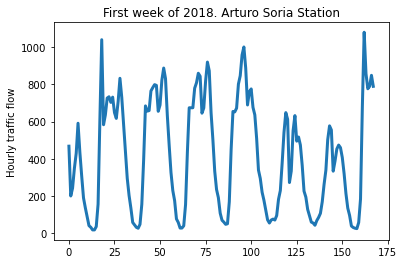

In [246]:
plt.plot(list(dataplot['obj'][0:24*7]),
        label=index, linewidth=3)
plt.title('First week of 2018. Arturo Soria Station')
plt.ylabel('Hourly traffic flow')
plt.show()

## Model development. 

We reshape our data to have the structure required by the neural network. 

In [109]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2])).astype('float32')
y = y.reshape((y.shape[0], y.shape[1], y.shape[2])).astype('float32')

We divide randomly our data in the train and test sets. 

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

We develop our model by using keras and tensorflow. First, we apply a convolutional neural network with 256 kernels which is followed by a max pooling. Then, we flatten data. 

Subsequently, we use the flatten data as input in the Bidirectional long short term memory network, with 500 units. It is followed by a dropout layer and, finally, we apply a dense layer to obtain the required prediction. 

In [120]:
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=256, kernel_size=2, activation='relu'), input_shape=(4,9,1)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model3.add(TimeDistributed(Flatten()))
model3.add(Bidirectional(LSTM(500, activation = 'relu')))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.compile(optimizer = 'adam', loss = 'mae')

We provide a graphical representation of the model by using Netron. Reader can deeply analyse each layer of the model. 

In [122]:
model3.save('model.h5')
netron.start('model.h5')

Serving 'model.h5' at http://localhost:8080


('localhost', 8080)

We train the model.

In [123]:
history3=model3.fit(X_train,y_train,epochs=100,batch_size = 32, shuffle=True,validation_data=(X_test,y_test))

Epoch 1/100
657/657 [==============================] - 71s 106ms/step - loss: 241.0814 - val_loss: 190.7856
Epoch 2/100
657/657 [==============================] - 68s 104ms/step - loss: 173.8271 - val_loss: 146.5818
Epoch 3/100
657/657 [==============================] - 68s 104ms/step - loss: 150.8029 - val_loss: 132.6890
Epoch 4/100
657/657 [==============================] - 69s 105ms/step - loss: 144.2565 - val_loss: 132.1290
Epoch 5/100
657/657 [==============================] - 70s 107ms/step - loss: 135.9356 - val_loss: 118.6247
Epoch 6/100
657/657 [==============================] - 70s 107ms/step - loss: 128.7651 - val_loss: 119.1878
Epoch 7/100
657/657 [==============================] - 68s 104ms/step - loss: 123.1257 - val_loss: 109.8890
Epoch 8/100
657/657 [==============================] - 72s 110ms/step - loss: 120.0189 - val_loss: 106.0444
Epoch 9/100
657/657 [==============================] - 69s 104ms/step - loss: 115.8272 - val_loss: 107.2274
Epoch 10/100
657/657 [======

657/657 [==============================] - 68s 103ms/step - loss: 70.9163 - val_loss: 66.9596
Epoch 78/100
657/657 [==============================] - 68s 103ms/step - loss: 70.5018 - val_loss: 66.5123
Epoch 79/100
657/657 [==============================] - 68s 103ms/step - loss: 70.4080 - val_loss: 66.0453
Epoch 80/100
657/657 [==============================] - 68s 103ms/step - loss: 69.9882 - val_loss: 66.4021
Epoch 81/100
657/657 [==============================] - 70s 106ms/step - loss: 70.2513 - val_loss: 64.6908
Epoch 82/100
657/657 [==============================] - 71s 107ms/step - loss: 70.3361 - val_loss: 66.0763
Epoch 83/100
657/657 [==============================] - 65s 99ms/step - loss: 69.7801 - val_loss: 68.2007
Epoch 84/100
657/657 [==============================] - 65s 99ms/step - loss: 69.2984 - val_loss: 63.9239
Epoch 85/100
657/657 [==============================] - 65s 99ms/step - loss: 68.9812 - val_loss: 66.2811
Epoch 86/100
657/657 [==============================]

## Model evaluation

We define this function, which will be useful to evaluate the model.

In [128]:
def flatten(t):
    return [item for sublist in t for item in sublist]

We evaluate the model by using the first metric (mean absolute error). 

In [130]:
pred = model3.predict(X_test)
MAE = MAE(flatten(pred),flatten(y_test))
print(MAE)

64.44088


We will evaluate the model with the second metric (accuracy). For this, we divide target variable in three categories: first, data between percentil 0 and 15; second, data between percentil 15 and 85 and thrid, data between percentil 85 and 100. 

In [134]:
obj = list(data['obj'].values)

In [138]:
print(np.quantile(obj, 0))
print(np.quantile(obj, 0.15))
print(np.quantile(obj, 0.85))
print(np.quantile(obj, 1))

0
48.0
838.0
2888



We add and substract a small value in extreme values in order to avoid issues. We also transform the predictions lower than 0 in 0. 

In [154]:
bins = [np.quantile(obj, 0)-0.001,np.quantile(obj, 0.15),np.quantile(obj, 0.85),np.quantile(obj, 1)+0.001]
names = ['a','b','c']
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
pred2=pd.cut(flatten(pred), bins, labels = names)
ytest2=pd.cut(flatten(flatten(y_test)), bins, labels = names)

We obtain the accuracy metric and the confusion matrix corresponding. 

In [157]:
print(accuracy_score(ytest2,pred2))
print(confusion_matrix(ytest2,pred2))

0.8747464992757122
[[1223  306    0]
 [ 214 6815  260]
 [   0  517 1020]]


###  Plotting the actual and predicted values. 

We selelct randomly an observation of the entire dataset and we will analyse the 100 successive observations. We plot
the actual and the predicted values of these observations. 

In [242]:
rand = randint(0, 30000)
rand

17742

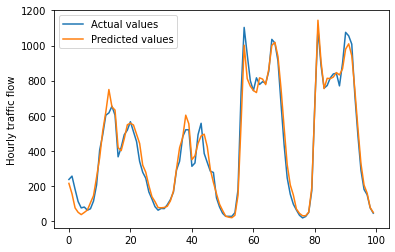

In [247]:
plt.plot(flatten(flatten(y[rand:rand+100])), label = "Actual values")
plt.plot(flatten(model3.predict(X[rand:rand+100])), label = "Predicted values")
plt.legend()
plt.ylabel('Hourly traffic flow')
plt.show()